## Import the necessary Libraries

In [4]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.spatial.distance import pdist, cdist, squareform
from matplotlib import pyplot as plt
import networkx as nx
import os
from sklearn.metrics import mean_squared_error
from pygsp import graphs

from IPython.display import display, clear_output
%matplotlib inline

In [5]:
DATA_PATH = '../data/ml-100k-convert/'
os.getcwd()

'/home/ng/MovieRecommendation/src'

## Load the ratings database

In [6]:
# Load data
lens_ratings = pd.read_csv(DATA_PATH+'data.tsv', sep='\t', names=['UserId', 'MovieId', 'Ratings', 'Timestamp'])
print(lens_ratings.shape)
# Get rid of timestamp
lens_ratings = lens_ratings.drop(columns=['Timestamp'])
lens_ratings.head()

(100000, 4)


,UserId,MovieId,Ratings
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


Look at some of the features of the Data

In [7]:
nb_users = len(lens_ratings.UserId.unique())
nb_movies = len(lens_ratings.MovieId.unique())
print('There are {} users'.format(nb_users))
print('There are {} movies'.format(nb_movies))

There are 943 users
There are 1682 movies


In [8]:
# Pivot the table, put 0 when there are no ratings
ratings = pd.pivot_table(lens_ratings, index='UserId', columns='MovieId', values='Ratings', fill_value=0)
ratings

MovieId,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
UserId,,,,,,,,,,,,,,,,,,,,,
1,5,3,4,3,3,5,4,1,5,3,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,4,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,0,0,0,0,0,0,0,0,5,0,...,0,0,0,0,0,0,0,0,0,0
940,0,0,0,2,0,0,4,5,3,0,...,0,0,0,0,0,0,0,0,0,0
941,5,0,0,0,0,0,4,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We genereate a test and a learning dataset based on a 70:30 split. The mask is randomly distributed over the whole pivot table.

In [9]:
mask = np.random.rand(*ratings.shape) < 0.7
ratings_np = ratings.to_numpy()
rating_train = ratings_np.copy()
rating_test = ratings_np.copy()
rating_train[~mask] = 0
rating_test[mask] = 0
mask.shape

(943, 1682)

What is the distrubition of movies rated by a user?
as well as the maximum and minimum ratings:

Number of movies rated per user: mean: 106.0, max: 20, min: 737


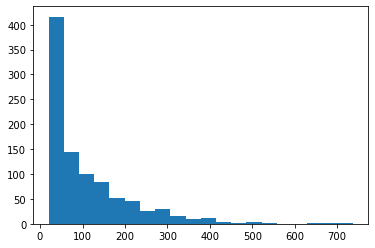

In [10]:
plt.hist(np.count_nonzero(ratings, axis=1),bins=20)
cnt = np.count_nonzero(ratings, axis=1)
print(f'Number of movies rated per user: mean: {cnt.mean():.1f}, max: {cnt.min()}, min: {cnt.max()}')

Here we define distance and weight functions that can be used with pdist and cdist to generate a distance matrix of the users.

In [11]:
def user_distance(ratingsA, ratingsB):
    #print(len(ratingsA),len(ratingsB))
    diff_ratings = []
    n = 0
    for x, y in zip(ratingsA, ratingsB):
        if x != 0 and y != 0:
            n += 1
            diff_ratings.append((x - y)**2)
    if diff_ratings:
        return np.mean(diff_ratings) / n
    else:
        return np.inf
    
def user_distance2(ratingsA, ratingsB):
    mask = np.intersect1d(ratingsA.nonzero()[0], ratingsB.nonzero()[0])
    diff_ratings = ((ratingsA[mask] - ratingsB[mask])**2)
    if diff_ratings.shape[0] > 0:
        cA = np.count_nonzero(ratingsA)
        cB = np.count_nonzero(ratingsB)
        #print(cA, cB, min(cA, cB))
        return np.mean(diff_ratings) + 1 * (1 / diff_ratings.shape[0]) ** 2 + 0.6 * (np.abs(cA - cB) / min(cA, cB))**2.
    else:
        return np.inf
    
def user_weight_simple(ratingsA, ratingsB):
    mask = np.intersect1d(ratingsA.nonzero()[0], ratingsB.nonzero()[0])
    diff_ratings = np.abs((ratingsA[mask] - ratingsB[mask]))
    return np.sum(4 - diff_ratings) / (np.count_nonzero(ratingsA))

def count_intersect(ratingsA, ratingsB):
    mask = np.intersect1d(ratingsA.nonzero()[0], ratingsB.nonzero()[0])
    diff_ratings = np.abs((ratingsA[mask] - ratingsB[mask]))
    return diff_ratings.shape[0]

Here a little sample rating file is defined with arbitrary numbers, that can be used to check the output

In [12]:
#weight_matrix = squareform(pdist(ratings_norm, user_weight_simple))
ratings_sample = ([[0,1,5,0,3,1,0],[3,3,3,3,0,0,0],[0,5,1,0,1,4,0],[4,5,1,0,0,5,0]])
pd.DataFrame(ratings_sample)

,0,1,2,3,4,5,6
0,0,1,5,0,3,1,0
1,3,3,3,3,0,0,0
2,0,5,1,0,1,4,0
3,4,5,1,0,0,5,0


## Calculate the distance between all the users. 
This matrix will not be symmetric, hence we use the cdist.

In [13]:
#weight_matrix = squareform(pdist(ratings_test, user_weight_simple))
weight_matrix = (cdist(rating_train, rating_train, user_weight_simple))
np.fill_diagonal(weight_matrix,0)

Look at the structure of `weight_matrix`

In [14]:
print(np.min(weight_matrix), np.max(weight_matrix), np.mean(weight_matrix))
pd.DataFrame(weight_matrix)

0.0 3.259259259259259 0.41462800263209176


,0,1,2,3,4,5,6,7,8,9,...,933,934,935,936,937,938,939,940,941,942
0,0.000000,0.115385,0.016484,0.000000,0.576923,0.763736,1.010989,0.274725,0.043956,0.648352,...,0.521978,0.049451,0.362637,0.093407,0.241758,0.109890,0.302198,0.093407,0.148352,0.609890
1,0.488372,0.000000,0.162791,0.209302,0.209302,1.139535,0.558140,0.186047,0.069767,0.348837,...,0.488372,0.348837,1.093023,0.581395,1.023256,0.558140,0.395349,0.302326,0.395349,0.348837
2,0.076923,0.179487,0.000000,0.179487,0.076923,0.538462,0.564103,0.102564,0.051282,0.256410,...,0.128205,0.102564,0.512821,0.256410,0.205128,0.076923,0.435897,0.179487,0.333333,0.179487
3,0.000000,0.692308,0.538462,0.000000,0.230769,0.461538,0.538462,0.846154,0.230769,0.384615,...,0.307692,0.000000,0.846154,0.538462,0.538462,0.230769,1.153846,0.461538,1.000000,0.230769
4,0.882353,0.075630,0.025210,0.025210,0.000000,0.655462,0.991597,0.243697,0.033613,0.369748,...,0.806723,0.100840,0.285714,0.100840,0.210084,0.134454,0.361345,0.075630,0.159664,0.873950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
938,0.555556,0.666667,0.083333,0.083333,0.444444,0.750000,0.666667,0.222222,0.000000,0.416667,...,0.361111,0.583333,1.083333,0.500000,1.250000,0.000000,0.333333,0.305556,0.194444,0.472222
939,0.808824,0.250000,0.250000,0.220588,0.632353,0.985294,1.029412,0.279412,0.147059,0.764706,...,1.073529,0.279412,0.455882,0.264706,0.367647,0.176471,0.000000,0.117647,0.617647,0.558824
940,1.133333,0.866667,0.466667,0.400000,0.600000,1.066667,0.466667,0.466667,0.533333,0.666667,...,0.266667,0.533333,1.466667,1.200000,1.066667,0.733333,0.533333,0.000000,0.666667,0.733333
941,0.490909,0.309091,0.236364,0.236364,0.345455,1.127273,1.400000,0.363636,0.000000,0.618182,...,0.618182,0.218182,0.345455,0.218182,0.290909,0.127273,0.763636,0.181818,0.000000,0.672727


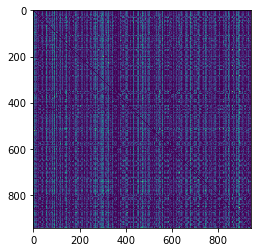

In [15]:
plt.imshow(weight_matrix)
plt.show()

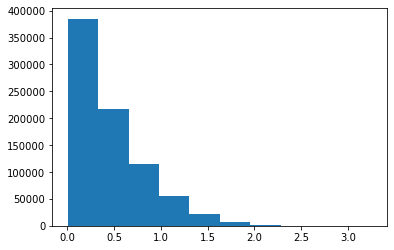

In [16]:
plt.hist(weight_matrix[weight_matrix > 0].flatten())
plt.show()

The following cells can be used to determine the number of commonly rated movies between two users. 

intersect_matrix = squareform(pdist(rating_train, count_intersect))

Define an epsilon kernel (epsilon similarity matrix)

In [17]:
def epsilon_kernel(X: np.ndarray, sigma=1, epsilon=0):
    """ X (n x d): distance matrix
        sigma (float): width of the kernel
        epsilon (float): threshold
        Return:
        adjacency (n x n ndarray): adjacency matrix of the graph.
    """
    adjacency = np.exp( - X / (2 * (sigma ** 2)))
    adjacency[adjacency < epsilon] = 0
    np.fill_diagonal(adjacency, 0)
    return adjacency

## Prediction function
Here we define the prediction function
It takes the weights of one user to the other users, as well as the rating table as input. 
The weights vector for the users is expand to a matrix of the size of the ratings and we set the weights for the unrated movies to zeros. This makes it possible to normalize the weights of each movie row. This matrix is element-wise multiplied with the given ratings matrix. Finally the weighted ratings for every movie are summed, to get a predicted rating for every movie

In [18]:
i_user = 12
variance = 900

#ratings_np = ratings_np[:variance,:]
ratings_np.shape
rating_mask = (ratings_np != 0).astype(float)

def predictRating(user_corr, ratings ):
    rating_mask = (ratings != 0).astype(float)
    #user_corr = np.random.rand(user_corr.shape[0])
    #user_corr = np.random.rand(user_corr.shape[0])
    user_corr = user_corr
    #user_corr[user_corr == 4] = 0
    #np.kron(user_corr[:4])
    #user_corr[:4].shape)
    user_corr_expand = (np.ones((ratings.shape[1],1)) @ (user_corr.reshape((1,user_corr.shape[0])))).T * rating_mask 
    user_corr_exp_norm = user_corr_expand / (user_corr_expand.sum(axis=0)[np.newaxis, :] + 1E-10)
    user_corr_exp_norm[np.isnan(user_corr_exp_norm)] = 0
    weighted_ratings = ratings * user_corr_exp_norm
    pred_ratings = weighted_ratings.sum(axis = 0)
    return pred_ratings


## use the train dataset
pred_ratings = predictRating(weight_matrix[i_user,:].copy(), ratings_train)

NameError: name 'ratings_train' is not defined

Possibility to look at the different intermediate matrices.

We can see that the ratings are in the expected range and the structure of the distribution seems reasonable.

In [ ]:
pd.DataFrame(pred_ratings).head()

In [ ]:
plt.hist(pred_ratings)

### Correlation display
Here we compare the ground truth rating (x-axis) with the predicted ratings. We see a trend in the right direction.

In [ ]:
plt.scatter(ratings_np[i_user,:],pred_ratings)
plt.show()


The same grafik can be plotted by violinplots, which show the distribution of the predicted Ratings.
To see possible correlations the general average rating vor the movie is plotted for every .5 entry
For this display we currently use all available ratings of the user.

In [ ]:
ratings_user = ratings_np[i_user,:]
mean_counter = ratings_np.copy().astype('float')
mean_counter[mean_counter == 0] = np.nan
mean_ratings = np.nanmean(mean_counter, axis = 0)
df1 = pd.DataFrame({ 'True' :ratings_np[i_user,:], 'predict' : pred_ratings})
df2 = pd.DataFrame({ 'True' : ratings_np[i_user,:] + 0.5, 'predict' : mean_ratings})
df = pd.concat([df1, df2])


sns.violinplot(x='True', y='predict', data=df, palette='Paired') #,split=True)
sns.stripplot(x='True', y='predict', data=df, color="red",jitter=0.2,dodge=True, size=3, alpha=0.3,linewidth=1)

In [ ]:
calculate the error of the predicted rating in comparison to the error of just taking the averages. 

In [ ]:
error = np.sqrt(mean_squared_error(ratings_user[ratings_user != 0], pred_ratings[ratings_user != 0]))
error_avg = np.sqrt(mean_squared_error(ratings_user[ratings_user != 0], mean_ratings[ratings_user != 0]))
print(error, error_avg, np.count_nonzero(ratings_user != 0))

## all users
here we want to calculate the error for all ratings. Herefore we use the train split for the entire prediction part. Thereafter we use the test split to calculate the errors.

In [ ]:
errors = []
pred_ratings = np.zeros(ratings_np.shape)
for ii in range(weight_matrix.shape[0]):
    pred_rating = predictRating(weight_matrix[ii,:].copy(), rating_train)
    pred_ratings[ii,:] = pred_rating
    #pred_rating = predictRating(np.random.rand(nn_weight_mat.shape[0]), ratings_np)
    ratings_user = rating_test[ii,:]
    errors.append(np.sqrt(mean_squared_error(ratings_user[ratings_user != 0], np.round(pred_rating[ratings_user != 0]))))
    #errors.append(np.sqrt(mean_squared_error(ratings_user[ratings_user != 0],(1+ 4 * np.random.rand(np.count_nonzero(ratings_user))))))
    if ii % 10 == 0:
        clear_output(wait=True)
        display(ii,np.average(errors))
#     if ii % 5 == 0:
#         #clear_output(wait=True)
#         line1.set_xdata(range(len(errors)))
#         line1.set_ydata(errors)
#         fig.canvas.draw()
#         fig.canvas.flush_events()
#         #plt.plot(errors)
#         plt.show()

In [ ]:
plt.hist(sorted(errors), bins=15)
plt.title(f'{np.average(errors):.4f}')
plt.xlim(0,2.5)
plt.show()
plt.plot(sorted(errors))
plt.show()

We see that our error is not too bad and way better than just the averages.
We want to test if this can be improved by using the predictions and perform a second run, so that the friends friends corrections can be seen.

In [ ]:
plt.plot(sorted(pred_ratings[rating_test != 0] - rating_test[rating_test != 0]))

In [ ]:
ratings2 = pred_ratings.copy()
ratings2[rating_train != 0] = 0
ratings2 += rating_train

In [ ]:
weight_matrix2 = squareform(pdist(ratings2, user_weight_simple))
np.fill_diagonal(weight_matrix2,0)
plt.imshow(weight_matrix2)

In [ ]:
errors2 = []
pred_ratings2 = np.zeros(ratings_np.shape)
for ii in range(weight_matrix.shape[0]):
    pred_rating2 = predictRating(weight_matrix2[ii,:].copy(), rating_train)
    pred_ratings2[ii,:] = pred_rating2
    #pred_rating = predictRating(np.random.rand(nn_weight_mat.shape[0]), ratings_np)
    ratings_user = rating_test[ii,:]
    errors2.append(np.sqrt(mean_squared_error(ratings_user[ratings_user != 0], np.round(pred_rating2[ratings_user != 0]))))
    #errors.append(np.sqrt(mean_squared_error(ratings_user[ratings_user != 0],(1+ 4 * np.random.rand(np.count_nonzero(ratings_user))))))
    if ii % 10 == 0:
        clear_output(wait=True)
        display(ii,np.average(errors2))

We could improve a little bit, but not necessarily more than just the variations of the available samples.

Another approach will be to use the movie feature graph and perform signal filtering to improve our results.

In [ ]:
graph = nx.read_gexf('../generated/movie_genre_dense.gexf')
adjacency = nx.to_numpy_matrix(graph)

In [ ]:
plt.spy(adjacency)

In [ ]:
G = graphs.Graph(adjacency)
G.set_coordinates()
G.compute_laplacian('normalized')
G.compute_fourier_basis()

In [ ]:
user = 1
signal = ratings2[user].copy()
mask = rating_train[user] != 0
val = (rating_test[user].copy()).astype(float)
val_mask = val != 0
val[~val_mask] = np.nan
signal, val

In [ ]:
fouriersig = G.gft(signal)
fouriersig

In [ ]:
plt.plot(fouriersig)

In [ ]:
def fit_polynomial(lam: np.ndarray, order: int, spectral_response: np.ndarray):
    """ Return an array of polynomial coefficients of length 'order'."""
    vander = np.vander(lam, order+1)
    return np.linalg.lstsq(vander, spectral_response)[0]

def polynomial_graph_filter_response(coeff: np.array, lam: np.ndarray):
    """ Return an array of the same shape as lam.
        response[i] is the spectral response at frequency lam[i]. """
    vander = np.vander(lam, len(coeff))
    return vander @ coeff

def polynomial_graph_filter(coeff: np.array, laplacian: np.ndarray):
    """ Return the laplacian polynomial with coefficients 'coeff'. """
    laplacian_poly = 0
    for i, coef in enumerate(coeff):
        deg = len(coeff) - i - 1
        laplacian_poly += coef * np.linalg.matrix_power(laplacian, deg)
    return laplacian_poly

## Tricky part 
here we have to get a good filter, which seems to be hard.

In [ ]:
ideal_lp = np.ones((G.n_vertices,))
ideal_lp[G.e < 1.005] = 0  # Low-pass filter with cut-off at lambda=0.1
ideal_lp[G.e > 1.6] = 0  # Low-pass filter with cut-off at lambda=0.1
ideal_filter = ideal_lp# Store your spectral response here

In [ ]:
#alpha = 0.99 / np.max(G.e)

#ideal_filter =  1/(1 + alpha*G.e)
ideal_filter = np.ones(G.e.shape)
#ideal_filter[G.e < 0.1] = 0
ideal_filter[G.e > 1.55] = 0
plt.plot(ideal_filter, label = 'filter')
plt.plot(G.e, label = 'eigenvalues')
plt.legend()
plt.show()
plt.scatter(G.e, ideal_filter)
plt.show()

In [ ]:
order =  4

coeff = fit_polynomial(G.e, order, ideal_filter)
graph_filter = polynomial_graph_filter(coeff, G.L.A)

In [ ]:
plt.plot(G.e, ideal_filter)
plt.scatter(G.e, polynomial_graph_filter_response(coeff, G.e),color='green')
# plt.yl
plt.plot(G.e, polynomial_graph_filter_response(coeff, G.e),'g')
plt.legend(['Ideal','P1_dot', 'Polynomial'])
plt.xlabel('$\lambda$')
plt.ylabel('Spectral response')
plt.show()

In [ ]:
graph_gcn_filter = polynomial_graph_filter(coeff, G.L.A)

In [ ]:
signal_filtered = (graph_gcn_filter) @ signal
signal_filtered_val = signal_filtered.copy()
signal_filtered_val[~val_mask] = np.nan

In [ ]:
fig, ax = plt.subplots(3, 4, sharey=True, figsize=(13, 9))
limits = [signal.min(), signal.max()]
_ = G.plot_signal(ratings_np[user], ax=ax[0,0], limits=limits, plot_name='Ground truth')

_ = G.plot_signal(signal, ax=ax[0,1], limits=limits, plot_name='Noisy')
signal_red = signal.copy()
signal_red[~val_mask] = np.nan
_ = G.plot_signal(signal_red, ax = ax[1,1], limits = limits, plot_name = 'noisy val')
_ = G.plot_signal(val, ax=ax[1,0], limits=limits, plot_name='Validation', show_edges=False)
_ = G.plot_signal(signal_filtered, ax=ax[0,2], limits=limits, plot_name='Recovery all')
_ = G.plot_signal(signal_filtered_val, ax=ax[1,2], limits=limits, plot_name='Recovery test')

ground_train = ratings_np[user].copy().astype(float)
signal_train = signal.copy()
filtered_train = signal_filtered.copy()
ground_train[~mask] = np.nan
signal_train[~mask] = np.nan
filtered_train[~mask] = np.nan
_ = G.plot_signal(ground_train, ax=ax[2,0], limits=limits, plot_name='Ground truth')
_ = G.plot_signal(signal_train, ax=ax[2,1], limits=limits, plot_name='signal learn')
_ = G.plot_signal(filtered_train, ax=ax[2,2], limits=limits, plot_name='filtered learn')
for i,av in enumerate(ax):
    for j, v in enumerate(av):
        ax[i,j].set_ylim([-0.25,0.25])
        ax[i,j].set_xlim([-0.25,0.25])
_ = fig.tight_layout()

In [ ]:
print(np.sqrt(mean_squared_error(val[val_mask], signal[val_mask])),
np.sqrt(mean_squared_error(val[val_mask], signal_filtered[val_mask])))

Here we see that for the current filter. The signal validation data will be worsened by additional graph filtering.